# Machine Learning Essentials SS25 - Exercise Sheet 2

## Instructions
- `TODO`'s indicate where you need to complete the implementations.
- You may use external resources, but <b>write your own solutions</b>.
- Provide concise, but comprehensible comments to explain what your code does.
- Code that's unnecessarily extensive and/or not well commented will not be scored.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import multivariate_normal
np.random.seed(42)

## Exercise 1 - Code Part

In [3]:
# Compute QDA and LDA decision boundaries
quadrat_qda = lambda cov_A, cov_B: (np.linalg.inv(cov_A) - np.linalg.inv(cov_B))
weight_qda = lambda cov_A, cov_B, mu_A, mu_B: -2 * (mu_A.T @ np.linalg.inv(cov_A) - mu_B.T @ np.linalg.inv(cov_B))
bias_qda = lambda cov_A, cov_B, mu_A, mu_B: (mu_A.T @ np.linalg.inv(cov_A) @ mu_A) - (mu_B.T @ np.linalg.inv(cov_B) @ mu_B) + np.log(np.linalg.det(cov_B) / np.linalg.det(cov_A))
weight_lda = lambda pooled_cov, mu_A, mu_B: (mu_B - mu_A).T @ np.linalg.inv(pooled_cov)
bias_lda = lambda pooled_cov, mu_A, mu_B: (mu_A.T @ np.linalg.inv(pooled_cov) @ mu_A) - (mu_B.T @ np.linalg.inv(pooled_cov) @ mu_B)
# qda = lambda x, Q, w, b: x.T @ Q @ x + w.T @ x + b
# lda = lambda x, w, b: x.T @ w + b

mu_A = np.array([[-1], [-1]])
mu_B = np.array([[1], [1]])
cov_A = np.array([[1, 0.3], [0.3, 1]])
cov_B = np.array([[1.5, -0.2], [-0.2, 1.5]])
pooled_cov = (cov_A + cov_B) / 2

Q_qda = quadrat_qda(cov_A, cov_B)
w_qda = weight_qda(cov_A, cov_B, mu_A, mu_B)
b_qda = bias_qda(cov_A, cov_B, mu_A, mu_B)
w_lda = weight_lda(pooled_cov, mu_A, mu_B)
b_lda = bias_lda(pooled_cov, mu_A, mu_B)

print("Q_qda:\n", Q_qda)
print("w_qda:\n", w_qda)
print("b_qda:\n", b_qda)
print("w_lda:\n", w_lda)
print("b_lda:\n", b_lda)

Q_qda:
 [[ 0.42016807 -0.42016807]
 [-0.42016807  0.42016807]]
w_qda:
 [[3.07692308 3.07692308]]
b_qda:
 [[0.8873032]]
w_lda:
 [[1.53846154 1.53846154]]
b_lda:
 [[0.]]


/var/folders/13/bkpcd1ns48v26qsfcl5kt1cc0000gn/T/ipykernel_60863/202944147.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z_qda[i] = (x.T @ Q_qda @ x) + (w_qda @ x) + b_qda


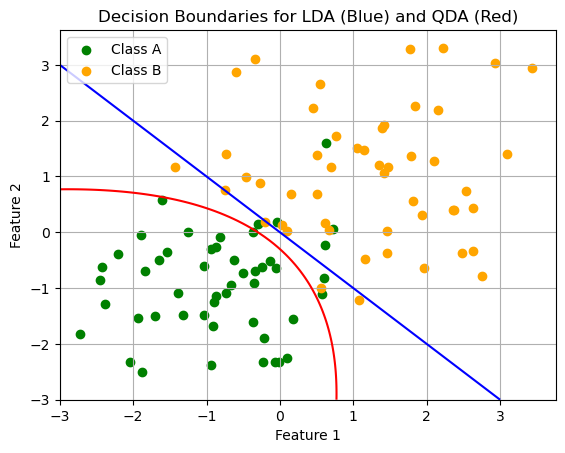

In [ ]:
# Plot decision boundaries
x_min, x_max = -3, 3
y_min, y_max = -3, 3
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = np.c_[xx.ravel(), yy.ravel()]

Z_lda = (grid @ w_lda.T + b_lda).reshape(xx.shape)
lda_contour = plt.contour(xx, yy, Z_lda, levels=[0], colors='blue')

grid_points = np.vstack([xx.ravel(), yy.ravel()]).T
Z_qda = np.zeros(grid_points.shape[0])

for i, point in enumerate(grid_points):
    x = point.reshape(-1, 1)
    Z_qda[i] = (x.T @ Q_qda @ x) + (w_qda @ x) + b_qda

Z_qda = Z_qda.reshape(xx.shape)
qda_contour = plt.contour(xx, yy, Z_qda, levels=[0], colors='red')

X_A = np.random.multivariate_normal(mu_A.flatten(), cov_A, 50)
X_B = np.random.multivariate_normal(mu_B.flatten(), cov_B, 50)
plt.scatter(X_A[:, 0], X_A[:, 1], color='green', label='Class A')
plt.scatter(X_B[:, 0], X_B[:, 1], color='orange', label='Class B')

plt.title('Decision Boundaries for LDA (Blue) and QDA (Red)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 2 - Implementing LDA

### Task 1

In [20]:
digits = load_digits()

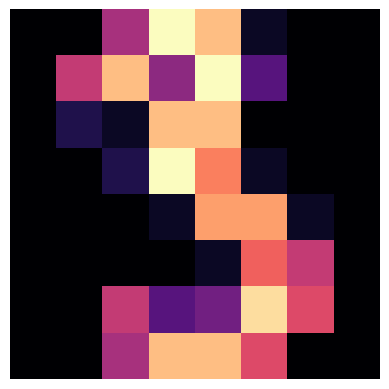

In [21]:
# TODO: Load digits dataset, visualize one example image of digit 30
digit_three = digits.images[np.where(digits.target==3)[0][0]]
plt.imshow(digit_three, interpolation='nearest', cmap='magma')
plt.axis('off')
plt.show()

### Task 2

In [79]:
# TODO: Filter the dataset to keep only digits 3 and 9, split into training and test set (train/test = 3/2)
features, labels = digits.data, digits.target
mask = (digits.target == 3) | (digits.target == 9)
X_filtered = features[mask]
y_filtered = labels[mask]

x_train, x_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered,
    train_size=0.6,
    test_size=0.4,
    stratify=y_filtered,
    random_state=42
)

### Task 3

In [80]:
# perform mean computation on train data
mean_three = x_train[y_train == 3].mean(axis=0)
mean_nine = x_train[y_train == 9].mean(axis=0)

# choose two pixels that appear most discriminative for distinguishing “3” from “9” (based on average images of each class)
diff_pix = np.argsort(np.abs(mean_three - mean_nine))[-2:]

def features_2d(x):
    """
    This function takes the 64x1 feature vectors and returns a 2D representation of the data.
    """
    # TODO: Design a 2D embedding of the data

    return x[diff_pix]

# TODO: Create an embedded dataset, provide a brief justification for your choice of embedding
embedd_ds = np.vstack([features_2d(x) for x in x_train])

## Justification: by computing the average brightness of each class and find the pixels that differs the most, we can distinguish 3 from 9 easier.


### Task 4

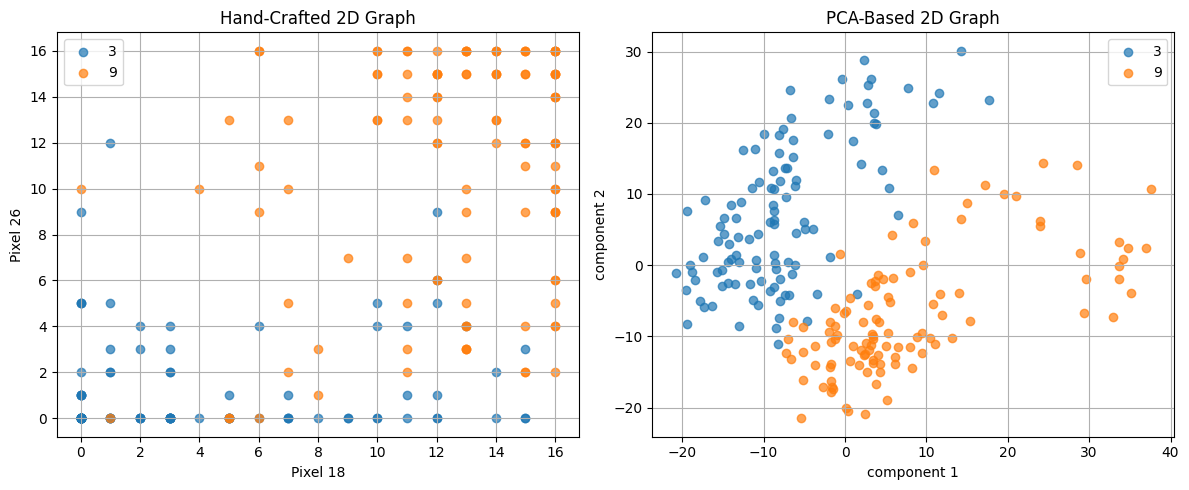

In [81]:
def pca_rep(x):
    """
    This function takes the 64x1 feature vectors and returns a 2D representation of the data. It uses PCA to reduce the dimensionality of the data to 2. PCA is a widely used algorithm for dimensionality reduction. Intuitively, PCA finds the directions in which the data varies the most and projects the data onto these directions.
    """
    # Standardize the data
    pca = PCA(n_components=2)
    return pca.fit_transform(x) 

# TODO: Create a PCA-embedded dataset. Visualize & compare the embeddings. Briefly discuss the differences in separation achieved by the embeddings.
PCA_ds = pca_rep(x_train)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Hand-crafted
axes[0].scatter(
    embedd_ds[y_train == 3, 0], embedd_ds[y_train == 3, 1],
    label='3', alpha=0.7
)
axes[0].scatter(
    embedd_ds[y_train == 9, 0], embedd_ds[y_train == 9, 1],
    label='9', alpha=0.7
)
axes[0].set_title("Hand-Crafted 2D Graph")
axes[0].set_xlabel(f"Pixel {diff_pix[0]}")
axes[0].set_ylabel(f"Pixel {diff_pix[1]}")
axes[0].legend()
axes[0].grid(True)

# PCA-based
axes[1].scatter(
    PCA_ds[y_train == 3, 0], PCA_ds[y_train == 3, 1],
    label='3', alpha=0.7
)
axes[1].scatter(
    PCA_ds[y_train == 9, 0], PCA_ds[y_train == 9, 1],
    label='9', alpha=0.7
)
axes[1].set_title("PCA-Based 2D Graph")
axes[1].set_xlabel("component 1")
axes[1].set_ylabel("component 2")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### The hand-crafted graph has a clear separation between two parts, most likely because it represent the greatest difference of the two digits
# The PCA embedding maximizes overall variance capture, so we see more overlap between “3” and “9” clusters in the PCA plot, however, we can still see a seperation of two parts

### Task 5

In [ ]:
def fit_lda(training_features, training_labels):
    """
    Compute LDA parameters.
    """
    # TODO: Implement LDA

    # remove dead pixels
    small_vari = np.var(training_features, axis=0)
    idx_keep = np.where(small_vari >= 0.001)[0] 
    filtered_df = training_features[:, idx_keep]

    N = filtered_df.shape[0]
    k = len(np.unique(training_labels))
    new_column = filtered_df.shape[1]
    mu = np.zeros((k, new_column))
    p = np.zeros(k)

    for i, j in enumerate(np.unique(training_labels)):
        x_i = filtered_df[training_labels == j]
        mu[i] = x_i.mean(axis=0)
        p[i] = x_i.shape[0]/N

    covmat = np.zeros((new_column, new_column))
    for i, j in enumerate(np.unique(training_labels)):
        x_i = filtered_df[training_labels == j]
        diff = x_i - mu[i]
        covmat += diff.T @ diff
        
    covmat /= N

    return mu, covmat, p

# TODO: Fit seperate LDA models using your hand-crafted embedding, the PCA embedding, and the original data.

mu_hand, cov_hand, p_hand = fit_lda(embedd_ds, y_train)
mu_pca,  cov_pca,  p_pca  = fit_lda(PCA_ds, y_train)
mu_full, cov_full, p_full = fit_lda(x_train, y_train)

Hand-crafted -> mu: (2, 2) cov: (2, 2)
PCA-based -> mu: (2, 2) cov: (2, 2)
Full 64 -> mu: (2, 55) cov: (55, 55)


### Task 6

In [83]:
def predict_lda(mu, covmat, p, test_features):
    """
    Predict labels using the LDA decision rule.
    """
    # TODO: Implement the LDA decision rule
    cov_inv = np.linalg.inv(covmat)
    w = np.linalg.inv(cov_inv) @ (mu[1] - mu[0])
    b = -1/2 * (mu[1] @ cov_inv @ mu[1] - mu[0] @ cov_inv @ mu[0]) + np.log(p[1]/p[0])
    y_1 = test_features @ w + b
    predicted_labels = np.where(y_1 >= 0, 1, -1)
    
    return predicted_labels

# TODO: Perform LDA on the filtered train sets of all 3 embeddings, evaluate on the respective test set. Report training and test error rates for all 3 embeddings. Error rate = 1 - accuracy.
y_train_lda = np.where(y_train == 3, -1, 1)
y_test_lda = np.where(y_test == 3, -1, 1)

# hand-craft and pca test data transform 2d feature
x_test_hand = np.vstack([features_2d(x) for x in x_test])
pca = PCA(n_components=2)
pca.fit(x_train)
x_test_pca = pca.transform(x_test)

# LDA prediction
y_pred_train_hand = predict_lda(mu_hand, cov_hand, p_hand, embedd_ds)
y_pred_test_hand = predict_lda(mu_hand, cov_hand, p_hand, x_test_hand)

y_pred_train_pca = predict_lda(mu_pca, cov_pca, p_pca, PCA_ds)
y_pred_test_pca = predict_lda(mu_pca, cov_pca, p_pca, x_test_pca)


var_train = np.var(x_train, axis=0)
var_lim = var_train >= 0.001

# Filter full train and test dataset by dropping dead features
x_train_filtered = x_train[:, var_lim]
x_test_filtered = x_test[:, var_lim]

y_pred_train_full = predict_lda(mu_full, cov_full, p_full, x_train_filtered)
y_pred_test_full = predict_lda(mu_full, cov_full, p_full, x_test_filtered)

# error function
def error_rate(y_true, y_pred):
    return 1 - np.mean(y_true == y_pred)

print("LDA Error Rates")
print(f"Hand-crafted features: Train = {error_rate(y_train_lda, y_pred_train_hand):.3f}, Test = {error_rate(y_test_lda, y_pred_test_hand):.3f}")
print(f"PCA-based features: Train = {error_rate(y_train_lda, y_pred_train_pca):.3f}, Test = {error_rate(y_test_lda, y_pred_test_pca):.3f}")
print(f"Full 64-dim features: Train = {error_rate(y_train_lda, y_pred_train_full):.3f}, Test = {error_rate(y_test_lda, y_pred_test_full):.3f}")

LDA Error Rates
Hand-crafted features: Train = 0.332, Test = 0.342
PCA-based features: Train = 0.041, Test = 0.075
Full 64-dim features: Train = 0.396, Test = 0.411


### Task 7

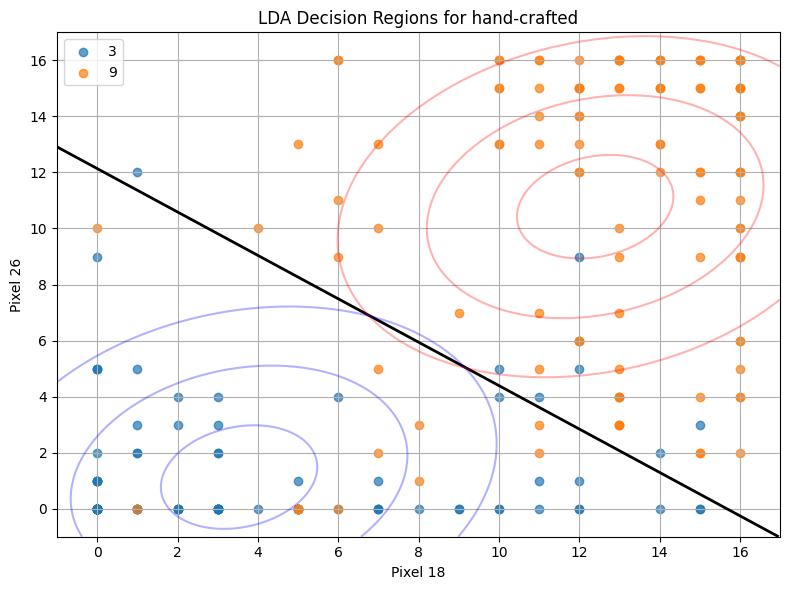

In [89]:
# TODO: For your hand-crafted embedding, visualize the decision boundary of the LDA classifier over a scatterplot of your data. Use a grid of points to visualize the decision boundary. Bonus: Visualize both Gaussian isocontours of the LDA model.

# build grid
margin = 1.0
x0_min, x0_max = embedd_ds[:,0].min() - margin, embedd_ds[:,0].max() + margin
x1_min, x1_max = embedd_ds[:,1].min() - margin, embedd_ds[:,1].max() + margin
xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 300),
                     np.linspace(x1_min, x1_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

cov_inv = np.linalg.inv(cov_hand)
w = cov_inv @ (mu_hand[1] - mu_hand[0])
b = (
    -1/2 * (mu_hand[1] @ cov_inv @ mu_hand[1]
            - mu_hand[0] @ cov_inv @ mu_hand[0])
    + np.log(p_hand[1] / p_hand[0])
)
Z = (grid @ w + b).reshape(xx.shape)

# plot

plt.figure(figsize=(8,6))
# decision boundary
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)

# scatter plot
plt.scatter(
    embedd_ds[y_train == 3, 0], embedd_ds[y_train == 3, 1],
    label='3', alpha=0.7
)
plt.scatter(
    embedd_ds[y_train == 9, 0], embedd_ds[y_train == 9, 1],
    label='9', alpha=0.7
)

# 4) bonus
rv3 = multivariate_normal(mean=mu_hand[0], cov=cov_hand)
rv9 = multivariate_normal(mean=mu_hand[1], cov=cov_hand)
Z3 = rv3.pdf(grid).reshape(xx.shape)
Z9 = rv9.pdf(grid).reshape(xx.shape)

plt.contour(xx, yy, Z3, levels=3, colors='blue', alpha=0.3)
plt.contour(xx, yy, Z9, levels=3, colors='red', alpha=0.3)

plt.title("LDA Decision Regions for hand-crafted")
plt.xlabel(f"Pixel {diff_pix[0]}")
plt.ylabel(f"Pixel {diff_pix[1]}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Task 8

In [88]:
from sklearn.model_selection import KFold

def cross_val_lda(X, y, n_splits):
    """
    Perform n-fold cross-validation for LDA using the earlier defined functions fit_lda and predict_lda."
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    errors = []

    # new train_test split
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_lda = np.where(y_train == 3, -1, 1)
        y_test_lda = np.where(y_test == 3, -1, 1)

        # Filter dead features
        var_train = np.var(X_train, axis=0)
        var_lim = var_train >= 0.001
        X_train_filt = X_train[:, var_lim]
        X_test_filt = X_test[:, var_lim]

        mu, cov, p = fit_lda(X_train_filt, y_train_lda)
        y_pred = predict_lda(mu, cov, p, X_test_filt)
        err = error_rate(y_test_lda, y_pred)
        errors.append(err)

    avg_error = np.mean(errors)
    return avg_error

# TODO: Perform 10-fold CV on the original data. Report average test error rate and its standard error. Compare with the test error rate of the LDA model trained on the full dataset.
avg_err = cross_val_lda(X_filtered, y_filtered, 10)
print("10-fold cross validation error: {:.3f}".format(avg_err))

# Compare with previous fixed test error from Task 6 which is 0.441, the 10-fold cross validation is indeed lower

10-fold cross validation error: 0.408


# Exercise 3 - Statistical Darts

### Task 1

In [ ]:
def simulate_data(mu_true, Sigma_true, n_samples):
    # TODO: Simulate data from a bivariate Gaussian distribution given the mean and covariance.
    data = np.random.multivariate_normal(mean=mu_true, cov=Sigma_true, size=n_samples) 
    return data

### Task 2

In [ ]:
def compute_mle(data):
    # TODO: Compute the MLE for the mean of a Gaussian distribution.
    mu_mle = np.mean(data, axis=0)
    return mu_mle

### Task 3

In [ ]:
def compute_posterior(data, prior, Sigma_true):
    # TODO: Compute the parameters of the posterior distribution for the unknown mean mu.
    n_samples = len(data)
    mu_mle = compute_mle(data)
    mu0 = prior['mu0']
    Sigma0 = prior['Sigma0']

    # Invert sigmas
    Sigma0_inv = np.linalg.inv(Sigma0)
    Sigma_true_inv = np.linalg.inv(Sigma_true)
    
    # Compte mu_post and sigma_post  (@ for matrix multiplicaton)
    Sigma_post = np.linalg.inv(Sigma0_inv + n_samples * Sigma_true_inv)
    mu_post = Sigma_post @ (Sigma0_inv @ mu0 + n_samples * Sigma_true_inv @ mu_mle)

    return mu_post, Sigma_post

def compute_map(data, prior, Sigma_true):
    # TODO: Assign mode of the posterior to mu_map.
    mu_map, _  = compute_posterior(data, prior, Sigma_true)
    return mu_map

### Task 4

In [ ]:
def visualize_inference(mu_true, mu_mle, mu_map, mu_post, Sigma_post, data,
                        grid_limits=[-1, 1, -1, 1], n_points=100):
    """
    Visualizes the full posterior distribution as Gaussian isocontours over a 2D grid with dartboard-like background,
    alongside the true mean, MLE estimate, MAP estimate and the simulated data points.

    Additional parameters:
        grid_limits: [xmin, xmax, ymin, ymax] limits for the 2D grid.
        n_points: Number of grid points per axis.
    """

    # Define the grid
    xmin, xmax, ymin, ymax = grid_limits
    x = np.linspace(xmin, xmax, n_points)
    y = np.linspace(ymin, ymax, n_points)
    X, Y = np.meshgrid(x, y)
    pos = np.dstack((X, Y))

    # Get the posterior distribution
    rv = multivariate_normal(mu_post, Sigma_post)
    # Evaluate the pdf of the posterior @ the grid points
    Z = rv.pdf(pos)
    
    # Compute some contour levels
    levels = np.linspace(Z.max()*0.05, Z.max()*0.95, 7)

    plt.figure(figsize=(8, 6), facecolor='white')

    # Plot a dartboard-like background (concentric circles)
    center = [0,0]
    radius = 0.8 
    for r in [radius, radius*0.8, radius*0.6, radius*0.4, radius*0.2]:
        circle = plt.Circle(center, r, fill=False, color='black')
        plt.gca().add_artist(circle)
    plt.axis('equal')

    # Add bullseye
    plt.plot(center[0], center[1], 'o', markersize=10, c='red')

    # Plot isocontours of  posterior
    contour = plt.contour(X, Y, Z, levels=levels, cmap='viridis',linewidths=1)

    # Add labels to the isocontours (off by default for visibility)
    # plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f")

    # Plot observed data points
    plt.scatter(data[:, 0], data[:, 1], c='gray', edgecolor='k', alpha=0.6, label='Data')

    # Plot true mean (ground truth)
    plt.scatter(mu_true[0], mu_true[1], c='black', marker='*', s=200, label='True aiming spot')

    # Plot MLE estimate
    plt.scatter(mu_mle[0], mu_mle[1], c='green', marker='x', s=100, label='MLE Estimate')

    # Plot MAP estimate 
    plt.scatter(mu_map[0], mu_map[1], c='blue', marker='x', s=100, label='MAP Estimate')

    plt.title("True Mean, posterior uncertainty, MLE & MAP on the dart board")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.grid(False)

    plt.show()

In [ ]:
# Ground truth parameters for the dart throws:
mu_true = np.array([0, 0.50])
Sigma_true = np.array([[0.05, 0.02],
                       [0.02, 0.04]])

# Prior for mu - standard normal around the bullseye
prior = {
    "mu0": np.array([0, 0]),
    "Sigma0": np.eye(2)
}

# TODO: Simulate data, compute MLE, MAP and posterior
n_samples = 10

data =simulate_data(mu_true, Sigma_true, n_samples)
mu_mle = compute_mle(data)
mu_map = compute_map(data, prior, Sigma_true)
posterior = compute_posterior(data,prior,Sigma_true)
mu_post, Sigma_post = posterior


# Visualize the inference
visualize_inference(mu_true, mu_mle, mu_map, mu_post, Sigma_post, data)
print(f"MLE estimate for N={n_samples}:", mu_mle)
print(f"MAP estimate for N={n_samples}:", mu_map)
print(f"Posterior covariance for N={n_samples}:\n", Sigma_post)

# TODO: Assess results (see exercise sheet)

# Task 4

posterior is broad &rarr; the player is inconsistent (more precision practice)
posterior is narrow but off-target &rarr; the player is mis-aiming (aim-practice)


# Task 5 

More concentrated prior &rarr; Prior dominates so that the posterior stays closer to prior 
Less informative prior &rarr; posterior is closer to MLE, the less informative the closer they are 

MLE ignores the prior, Posterior is influenced by MLE and the prior belive

# Task 6

1. If the prior is uninformative ($\Sigma_0 \to \infty$) 
2. If the prior is equal to MLE 

# Task 7

1. Estimating disease risk from patient data. (high uncertainty for medical test, should be reviewed by multiple doctors)
2. Weather Forecasting (a low confidence in the forecast would mean more preperation for multiple scenarios)